In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
import daft


In [2]:
divorces = pd.read_csv('./data/WaffleDivorce.csv', sep=';')

In [3]:
divorces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           50 non-null     object 
 1   Loc                50 non-null     object 
 2   Population         50 non-null     float64
 3   MedianAgeMarriage  50 non-null     float64
 4   Marriage           50 non-null     float64
 5   Marriage SE        50 non-null     float64
 6   Divorce            50 non-null     float64
 7   Divorce SE         50 non-null     float64
 8   WaffleHouses       50 non-null     int64  
 9   South              50 non-null     int64  
 10  Slaves1860         50 non-null     int64  
 11  Population1860     50 non-null     int64  
 12  PropSlaves1860     50 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 5.2+ KB


Text(0.5, 0, 'Median age marriage')

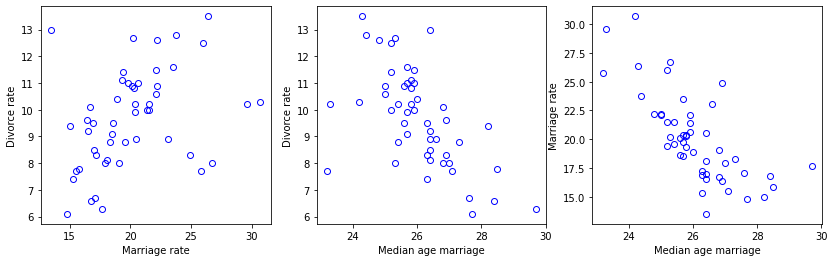

In [4]:
fid, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].scatter(divorces["Marriage"], divorces["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Marriage rate")

ax[1].scatter(divorces["MedianAgeMarriage"], divorces["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

ax[2].scatter(divorces["MedianAgeMarriage"], divorces["Marriage"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[2].set_ylabel("Marriage rate")
ax[2].set_xlabel("Median age marriage")

In [5]:
def standarize(s):
    return (s-np.mean(s))/np.std(s)

In [6]:
divorces['standarized_divorce'] = standarize(divorces['Divorce'])
divorces['standarized_marriage'] = standarize(divorces['Marriage'])
divorces['standarized_median_age_marriage'] = standarize(divorces['MedianAgeMarriage'])

# M1 Standarized Median Age at Marriage

*M1* will apply a regression over the standarized divorce rate using as only feature standarized median age at marriage.
Given that target and feature are standarized, slope can be interpreted as how much does one standard deviation change in feature affects target, in standard deviation of target units.

In [7]:
with pm.Model() as m1
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_median_age', 0, 2.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * divorces['standarized_median_age_marriage'])
    sdr = pm.Normal('standarized_divorce_rate', mu, sd=sigma, observed=divorces['standarized_divorce'])
    m1_trace = pm.sample(return_inferencedata=True)
    m1_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_median_age, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [8]:
np.std(divorces['MedianAgeMarriage']), np.std(divorces['Divorce'])

(1.231131187160816, 1.8025138002245642)

This means that if $\beta=1$ an increase in 1.2 years in median age marriage will affect divorce rate in 1 std deviation, which equals 1.80 more divorces

## Prior simulation

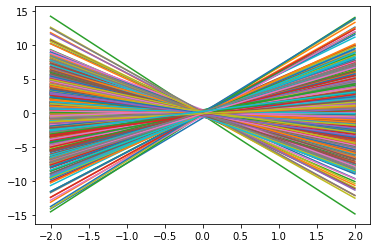

In [9]:
x = np.linspace(-2, 2, len(m1_prior_predictive['alpha']))

for a, b in zip(m1_prior_predictive['alpha'], m1_prior_predictive['beta_median_age']):
    plt.plot(x, a + b * x)

## Posterior simulation

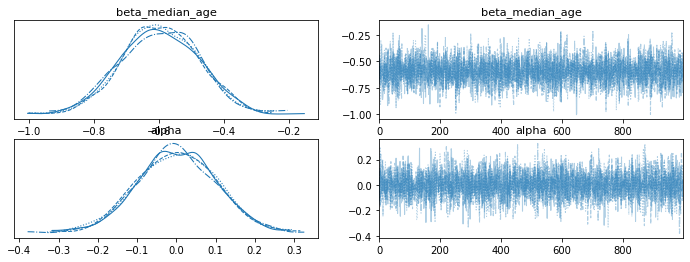

In [10]:
az.plot_trace(m1_trace, var_names=["beta_median_age", "alpha"]);

## Posterior Predictive

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'Divorce rate')

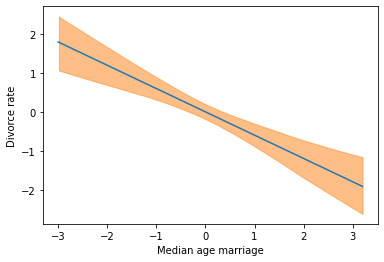

In [11]:
posterior = m1_trace.posterior.to_dataframe()
age_std_seq = np.linspace(-3, 3.2, 30)
mu_pred = np.zeros((len(age_std_seq), len(posterior)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = posterior["alpha"] + posterior["beta_median_age"] * age_std

mu_mean = mu_pred.mean(axis=1)

ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate")

In [12]:
m1_trace.posterior.to_dataframe()

alpha  beta_median_age     sigma        mu
chain draw mu_dim_0                                               
0     0    0         0.014792        -0.445756  0.627301  0.287793
           1         0.014792        -0.445756  0.627301  0.324000
           2         0.014792        -0.445756  0.627301  0.106758
           3         0.014792        -0.445756  0.627301  0.649864
           4         0.014792        -0.445756  0.627301 -0.255313
...                       ...              ...       ...       ...
3     999  45       -0.091479        -0.607579  0.780812 -0.262235
           46       -0.091479        -0.607579  0.780812 -0.015478
           47       -0.091479        -0.607579  0.780812  0.428683
           48       -0.091479        -0.607579  0.780812 -0.212884
           49       -0.091479        -0.607579  0.780812  0.823494

[200000 rows x 4 columns]

# M2 Standarized Marriage

In [ ]:
with pm.Model() as m2:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_marriage_rate', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * divorces['standarized_marriage'])
    sdr = pm.Normal('standarized_divorce_rate', mu, sd=sigma, observed=divorces['standarized_divorce'])
    m2_trace = pm.sample(return_inferencedata=True)
    m2_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_marriage_rate, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


## Prior simulation

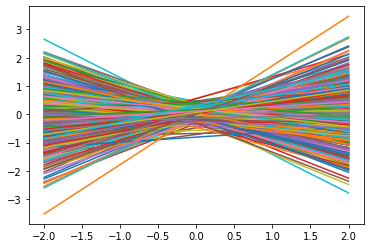

In [14]:
x = np.linspace(-2, 2, len(m2_prior_predictive['alpha']))

for a, b in zip(m2_prior_predictive['alpha'], m2_prior_predictive['beta_marriage_rate']):
    plt.plot(x, a + b * x)

## Posterior simulation

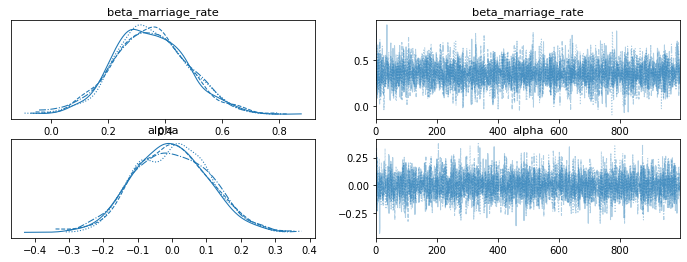

In [15]:
az.plot_trace(m2_trace, var_names=["beta_marriage_rate", "alpha"]);

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'Divorce rate')

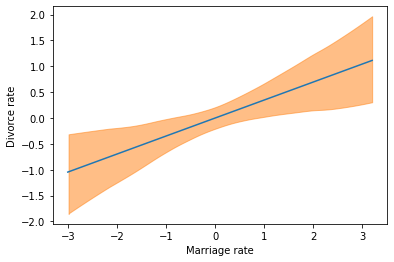

In [16]:
posterior = m2_trace.posterior.to_dataframe()
age_std_seq = np.linspace(-3, 3.2, 30)
mu_pred = np.zeros((len(age_std_seq), len(posterior)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = posterior["alpha"] + posterior["beta_marriage_rate"] * age_std

mu_mean = mu_pred.mean(axis=1)

ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Marriage rate")
ax.set_ylabel("Divorce rate")

# Intro to causal graphs

<Axes:>

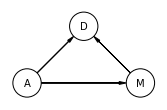

In [17]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


Coefficient of regressions are opaque, we can only attach a causal meaning if we have a DAG and assumme that DAG to be true. 

# M3 Multiple regression

In [18]:
with pm.Model() as m3:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_marriage_rate = pm.Normal('beta_marriage_rate', 0, 0.5)
    beta_median_Age = pm.Normal('beta_median_age', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_marriage_rate * divorces['standarized_marriage'] + beta_median_Age * divorces['standarized_median_age_marriage'])
    sdr = pm.Normal('standarized_divorce_rate', mu, sd=sigma, observed=divorces['standarized_divorce'])
    m3_trace = pm.sample(return_inferencedata=True)
    m3_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_median_age, beta_marriage_rate, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8789156507454392, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'beta_marriage_rate'}>,
        <AxesSubplot:title={'center':'beta_marriage_rate'}>],
       [<AxesSubplot:title={'center':'beta_median_age'}>,
        <AxesSubplot:title={'center':'beta_median_age'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

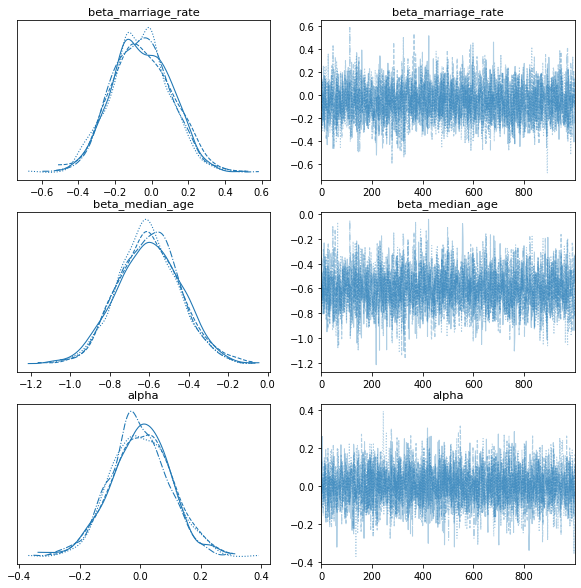

In [19]:
az.plot_trace(m3_trace, var_names=["beta_marriage_rate", "beta_median_age", "alpha"], figsize=(10,10))

In [20]:
az.summary(m3_trace, var_names=["beta_marriage_rate", "beta_median_age", "alpha"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_marriage_rate,-0.057,0.161,-0.339,0.250,0.003,0.002,2648.0,2483.0,1.0
beta_median_age,-0.603,0.161,-0.899,-0.298,0.003,0.002,2653.0,2739.0,1.0
alpha,0.002,0.099,-0.172,0.200,0.002,0.002,3500.0,2689.0,1.0


Although posterior mean of beta_marriage_rate is close to zero, there's a lot of probability on both sides of zero.


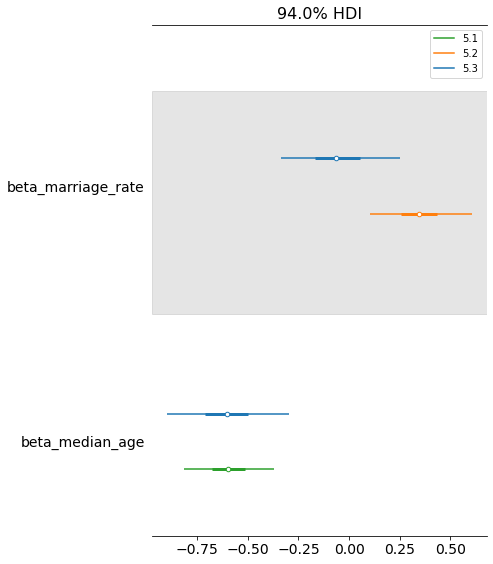

In [21]:
az.plot_forest(
    [
        m3_trace,
        m2_trace,
        m1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["beta_marriage_rate", "beta_median_age"],
    combined=True,
);

When including both models, we have more uncertainty on the impact of median_ age, but marriage rate becomes non-influential when both features are included.

In [22]:
divorces.columns

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860', 'standarized_divorce',
       'standarized_marriage', 'standarized_median_age_marriage'],
      dtype='object')

In [23]:
with pm.Model() as m3bis:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_median_age', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * divorces['standarized_median_age_marriage'])
    sdr = pm.Normal('standarized_marriage', mu, sd=sigma, observed=divorces['standarized_marriage'])
    m3bis_trace = pm.sample(return_inferencedata=True)
    m3bis_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_median_age, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [24]:
az.summary(m3bis_trace, var_names=["beta_median_age", "alpha"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_median_age,-0.695,0.103,-0.891,-0.500,0.001,0.001,5392.0,3068.0,1.0
alpha,0.001,0.091,-0.168,0.171,0.001,0.001,4924.0,2876.0,1.0


When analyzing multivariate regression, the author classifies diagnosis plots into three categories: Predictor residual plots, posterior prediction plots and counterfactual plots.

# Diagnosis plots

## Predictor residuals plots

Predictor residual: given predictor X from a set of predictors P, we try to estimate X using P-{X}. Let's call this estimate X'. Then X-X' is the predictor residual.

This is essentially running two regressions from one feature to the other, as below:

In [25]:
with pm.Model() as m4:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_median_Age = pm.Normal('beta_median_age', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_median_Age * divorces['standarized_median_age_marriage'])
    sdr = pm.Normal('standarized_marriage', mu, sd=sigma, observed=divorces['standarized_marriage'])
    m4_trace = pm.sample(return_inferencedata=True)
    m4_prior_predictive = pm.sample_prior_predictive()


with pm.Model() as m4_bis:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_median_Age = pm.Normal('beta_marriage_rate', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_median_Age * divorces['standarized_marriage'])
    sdr = pm.Normal('standarized_median_age_marriage', mu, sd=sigma, observed=divorces['standarized_median_age_marriage'])
    m4_bis_trace = pm.sample(return_inferencedata=True)
    m4_bis_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_median_age, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_marriage_rate, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [26]:
posterior_m4 = m4_trace.posterior.to_dataframe()
mean_predictions_m4 = posterior_m4['alpha'].mean() + posterior_m4['beta_median_age'].mean() * divorces['standarized_median_age_marriage']
residuals_m4 = divorces['standarized_marriage']-mean_predictions_m4
posterior_m4_bis = m4_bis_trace.posterior.to_dataframe()
mean_predictions_m4_bis = posterior_m4_bis['alpha'].mean() + posterior_m4_bis['beta_marriage_rate'].mean() * divorces['standarized_marriage']
residuals_m4_bis = divorces['standarized_median_age_marriage']-mean_predictions_m4_bis

In [27]:
with pm.Model() as m4_residuals:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_residuals_m4 = pm.Normal('beta_residuals_m4', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_residuals_m4 * residuals_m4)
    sdr = pm.Normal('standarized_divorce_rate', mu, sd=sigma, observed=divorces['standarized_divorce'])
    m4_residuals_trace = pm.sample(return_inferencedata=True)
    m4_residuals_prior_predictive = pm.sample_prior_predictive()

with pm.Model() as m4_bis_residuals:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_residuals_m4 = pm.Normal('beta_residuals_m4_bis', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_residuals_m4 * residuals_m4_bis)
    sdr = pm.Normal('standarized_divorce_rate', mu, sd=sigma, observed=divorces['standarized_divorce'])
    m4_bis_residuals_trace = pm.sample(return_inferencedata=True)
    m4_bis_residuals_prior_predictive = pm.sample_prior_predictive()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_residuals_m4, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_residuals_m4_bis, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8860261498459441, but should be close to 0.8. Try to increase the number of tuning steps.


In [28]:
posterior_m4 = m4_trace.posterior.to_dataframe()
mean_predictions_m4 = posterior_m4['alpha'].mean() + posterior_m4['beta_median_age'].mean() * divorces['standarized_median_age_marriage']

posterior_m4_bis = m4_bis_trace.posterior.to_dataframe()
mean_predictions_m4_bis = posterior_m4_bis['alpha'].mean() + posterior_m4_bis['beta_marriage_rate'].mean() * divorces['standarized_marriage']

Text(0.5, 1.0, 'Predictor residual of A given M')

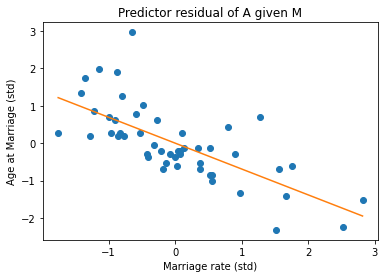

In [29]:
plt.plot(
    divorces["standarized_marriage"],
    divorces["standarized_median_age_marriage"],
    'o'
)
ls = np.linspace(min(divorces["standarized_marriage"]), max(divorces["standarized_marriage"]), 50)
plt.plot(ls, ls*posterior_m4_bis['beta_marriage_rate'].mean()+posterior_m4_bis['alpha'].mean())

plt.xlabel("Marriage rate (std)")
plt.ylabel("Age at Marriage (std)")
plt.title('Predictor residual of A given M')


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


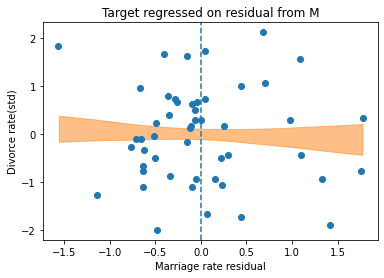

In [30]:
mu_mean  = m4_residuals_trace.posterior["mu"].mean(axis=0)
az.plot_hdi(residuals_m4, mu_mean)
plt.scatter(residuals_m4, divorces['standarized_divorce'])
plt.xlabel("Marriage rate residual")
plt.ylabel("Divorce rate(std)")
plt.title('Target regressed on residual from M')
plt.axvline(x=0, linestyle='--')



/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


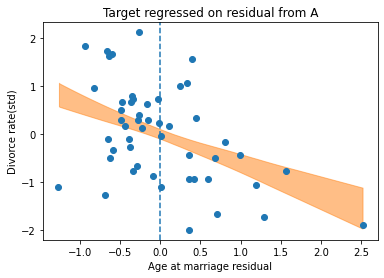

In [31]:
mu_mean = m4_bis_residuals_trace.posterior["mu"].mean(axis=0)
az.plot_hdi(residuals_m4_bis, mu_mean)
plt.scatter(residuals_m4_bis, divorces['standarized_divorce'])
plt.xlabel("Age at marriage residual")
plt.ylabel("Divorce rate(std)")
plt.title('Target regressed on residual from A')
plt.axvline(x=0, linestyle='--')

Text(0.5, 1.0, 'Predictor residual of M given A')

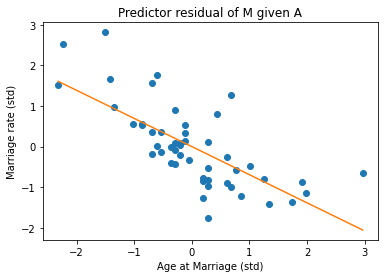

In [32]:
plt.plot(
    divorces["standarized_median_age_marriage"],
    divorces["standarized_marriage"],
    'o'
)
ls = np.linspace(min(divorces["standarized_median_age_marriage"]), max(divorces["standarized_median_age_marriage"]), 50)
plt.plot(ls, ls*posterior_m4['beta_median_age'].mean()+posterior_m4['alpha'].mean())
plt.ylabel("Marriage rate (std)")
plt.xlabel("Age at Marriage (std)")
plt.title('Predictor residual of M given A')

The author states that this kind of plots are useful from a learning perspective: they highglight the inner workings of multivariate regression. Appart from that, they are not so usefull
in practice, since the model does the work implicitely.

## Posterior prediction plots

Did the model correctly approximate the posterior distribution and how does the model fail

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_57125/1924292863.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hpd = az.hdi(m3_ppc["mu"], 0.89)


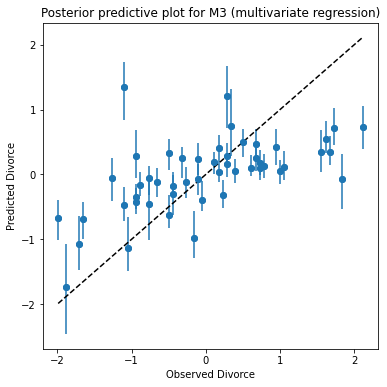

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))

with m3:
    m3_ppc = pm.sample_posterior_predictive(m3_trace, var_names=["mu", "standarized_divorce_rate"], samples=1000)

mu_hpd = az.hdi(m3_ppc["mu"], 0.89)
D_sim = m3_ppc["standarized_divorce_rate"].mean(axis=0)

plt.errorbar(
    divorces["standarized_divorce"],
    D_sim,
    yerr=np.abs(m3_ppc["standarized_divorce_rate"].mean(0) - mu_hpd.T),
    fmt="C0o",
)
ax.scatter(divorces["standarized_divorce"], D_sim)

min_x, max_x = divorces["standarized_divorce"].min(), divorces["standarized_divorce"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.title.set_text("Posterior predictive plot for M3 (multivariate regression)")

Just some checks to validate inner working's assumptions

In [34]:
m3_ppc['standarized_divorce_rate'].shape, len(divorces)

((1000, 50), 50)

In [35]:
az.hdi(m3_ppc["mu"], 0.89).shape, az.hdi(m3_trace.posterior["mu"], 0.89).dims

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_57125/2367214434.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(m3_ppc["mu"], 0.89).shape, az.hdi(m3_trace.posterior["mu"], 0.89).dims


((50, 2), Frozen({'mu_dim_0': 50, 'hdi': 2}))

divorces

In [36]:
m3_trace.posterior

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 1000, mu_dim_0: 50)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * mu_dim_0            (mu_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Data variables:
    alpha               (chain, draw) float64 0.06694 -0.06872 ... -0.04321
    beta_marriage_rate  (chain, draw) float64 0.02185 0.2309 ... -0.207 -0.1677
    beta_median_age     (chain, draw) float64 -0.3421 -0.485 ... -0.82 -0.7465
    sigma               (chain, draw) float64 0.8942 0.7163 ... 0.7888 0.8407
    mu                  (chain, draw, mu_dim_0) float64 0.277 0.3385 ... 0.6087
Attributes:
    created_at:                 2022-03-31T14:56:21.966553
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              17.538154125213623
    tuning_steps:               1000

In [37]:
divorces['prediction_by_m3'] = m3_ppc["standarized_divorce_rate"].mean(0)

In [38]:
divorces[divorces.Location.isin(('Idaho', 'Utah'))][['Location','standarized_divorce', 'prediction_by_m3']]

,Location,standarized_divorce,prediction_by_m3
12,Idaho,-1.102904,1.343636
43,Utah,0.284048,1.205226


## Counterfactual plots

'Counterfactual' means different things depending on the field. In this context, it means 'some computation that makes use of the structural causal model, going beyond the posterior distribution'. In summary, the idea is that we intervene some variable and simulate predictions, but taking into account some causal model. That could imply modifying other variables, depending on the structure.

We will start with a model where:
A->M
A->D
M->D

Recall that M3 ignored A->M

In order to understand the consequences that manipulating A has on D, we need both A->D and A->M, the latter since A may influence M through M.

In [39]:
from theano import shared

# M6

In [40]:
marriage_shared = shared(np.array(divorces["standarized_marriage"])) # Parameter to shared can't be a pandas series, needs to be an array
az. = shared(np.array(divorces["standarized_median_age_marriage"]))

with pm.Model() as M6:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=divorces["standarized_divorce"])

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=divorces["standarized_marriage"])

    m6_trace = pm.sample()

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [41]:
#Imaginary interventions
interventions_to_a = np.linspace(-2,2,50)
interventions_to_a

array([-2.        , -1.91836735, -1.83673469, -1.75510204, -1.67346939,
       -1.59183673, -1.51020408, -1.42857143, -1.34693878, -1.26530612,
       -1.18367347, -1.10204082, -1.02040816, -0.93877551, -0.85714286,
       -0.7755102 , -0.69387755, -0.6122449 , -0.53061224, -0.44897959,
       -0.36734694, -0.28571429, -0.20408163, -0.12244898, -0.04081633,
        0.04081633,  0.12244898,  0.20408163,  0.28571429,  0.36734694,
        0.44897959,  0.53061224,  0.6122449 ,  0.69387755,  0.7755102 ,
        0.85714286,  0.93877551,  1.02040816,  1.10204082,  1.18367347,
        1.26530612,  1.34693878,  1.42857143,  1.51020408,  1.59183673,
        1.67346939,  1.75510204,  1.83673469,  1.91836735,  2.        ])

In [42]:
age_shared.set_value(interventions_to_a)

with M6:
    m6_pp = pm.sample_posterior_predictive(m6_trace)


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


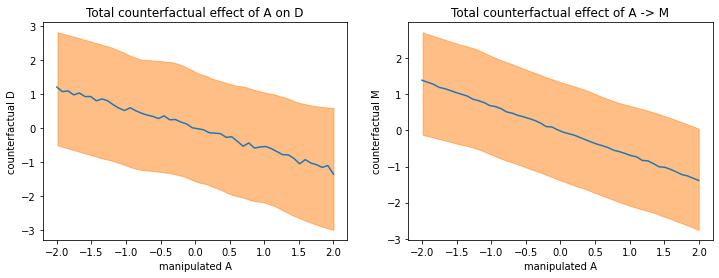

In [43]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(interventions_to_a, m6_pp["divorce"], ax=ax[0])
ax[0].plot(interventions_to_a, m6_pp["divorce"].mean(0))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(interventions_to_a, m6_pp["marriage"], ax=ax[1])
ax[1].plot(interventions_to_a, m6_pp["marriage"].mean(0))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

The left plot shows the posterior predictive distribution for different values of an artificial standarized_median_age_marriage. Since this is standarized, we are moving from -2 to +2 standard deviations in the original median ages. Right plot shows the posterior predictive distribution for those same manipulated values, but predicting M (standard number of marriages).


When we simulate counterfactuals and manipulate some variable X,  we break the causal influence of other variables on X.

# Masked relationship

In [44]:
milk = pd.read_csv('./data/milk.csv', sep=';')

In [45]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


In [46]:
milk = milk.dropna(subset=['neocortex.perc'])
milk['standarized_kcal_per_g'] = standarize(milk['kcal.per.g'])
milk['standarized_neocortex_perc'] = standarize(milk['neocortex.perc'])



# Regress kcal on neocortex

In [47]:
with pm.Model() as m5_5_draft:
    alpha = pm.Normal('alpha', 0, 1)
    beta = pm.Normal('beta_neocortex', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * milk['standarized_neocortex_perc'])
    K = pm.Normal('K', mu, sd=sigma, observed=milk['standarized_kcal_per_g'])
    m5_5_draft_trace = pm.sample(return_inferencedata=True)
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_neocortex, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


(-2.0, 2.0)

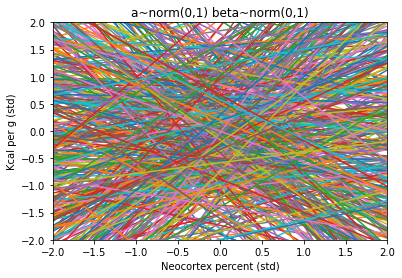

In [48]:
x = np.linspace(-2, 2, len(m5_5_draft_prior_predictive['alpha']))

for a, b in zip(m5_5_draft_prior_predictive['alpha'], m5_5_draft_prior_predictive['beta_neocortex']):
    plt.plot(x, a + b * x)
    
plt.xlabel('Neocortex percent (std)')
plt.ylabel('Kcal per g (std)')
plt.title('a~norm(0,1) beta~norm(0,1)')
plt.xlim((-2,2))
plt.ylim((-2,2))

In [49]:
with pm.Model() as m5_5_draft_2:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_neocortex', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * milk['standarized_neocortex_perc'])
    K = pm.Normal('K', mu, sd=sigma, observed=milk['standarized_kcal_per_g'])
    m5_5_draft_2_trace = pm.sample(return_inferencedata=True)
    m5_5_draft_2_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_neocortex, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


(-2.0, 2.0)

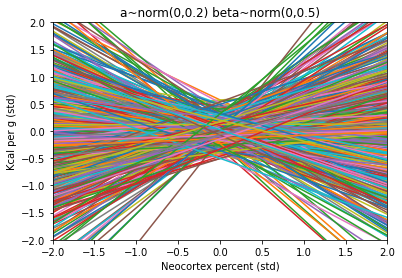

In [50]:
x = np.linspace(-2, 2, len(m5_5_draft_2_prior_predictive['alpha']))

for a, b in zip(m5_5_draft_2_prior_predictive['alpha'], m5_5_draft_2_prior_predictive['beta_neocortex']):
    plt.plot(x, a + b * x)
    
plt.xlabel('Neocortex percent (std)')
plt.ylabel('Kcal per g (std)')
plt.title('a~norm(0,0.2) beta~norm(0,0.5)')
plt.xlim((-2,2))
plt.ylim((-2,2))

In [51]:
az.summary(m5_5_draft_2_trace, var_names=["beta_neocortex", "alpha", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_neocortex,0.126,0.225,-0.299,0.543,0.003,0.003,4984.0,3057.0,1.0
alpha,0.005,0.160,-0.306,0.298,0.002,0.002,4508.0,2889.0,1.0
sigma,1.068,0.198,0.740,1.442,0.003,0.002,4667.0,2797.0,1.0


Regress kcal on mass

In [52]:
milk['standarized_log_mass'] = standarize(np.log(milk['mass']))


In [53]:
with pm.Model() as m5_6:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_log_mass', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * milk['standarized_log_mass'])
    K = pm.Normal('K', mu, sd=sigma, observed=milk['standarized_kcal_per_g'])
    m5_6_trace = pm.sample(return_inferencedata=True)
    m5_6_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_log_mass, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [54]:
az.summary(m5_6_trace, var_names=["beta_log_mass", "alpha", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_log_mass,-0.279,0.233,-0.727,0.140,0.004,0.003,4247.0,2909.0,1.0
alpha,0.001,0.156,-0.287,0.293,0.002,0.003,4706.0,2819.0,1.0
sigma,1.018,0.193,0.700,1.372,0.003,0.002,3535.0,2475.0,1.0


# Multivariate model

In [59]:
mass_shared = shared(np.array(milk["standarized_log_mass"])) # Parameter to shared can't be a pandas series, needs to be an array
neocortex_shared = shared(np.array(milk["standarized_neocortex_perc"])) # Parameter to shared can't be a pandas series, needs to be an array

with pm.Model() as m5_7:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_mass = pm.Normal('beta_log_mass', 0, 0.5)
    beta_neo = pm.Normal('beta_neocortex', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_mass * mass_shared + beta_neo * neocortex_shared)
    K = pm.Normal('K', mu, sd=sigma, observed=milk['standarized_kcal_per_g'])
    m5_7_trace = pm.sample(return_inferencedata=True)
    m5_7_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_neocortex, beta_log_mass, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [60]:
az.summary(m5_7_trace, var_names=["beta_log_mass", "beta_neocortex", "alpha", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_log_mass,-0.674,0.266,-1.182,-0.185,0.006,0.004,2015.0,2136.0,1.0
beta_neocortex,0.569,0.265,0.072,1.063,0.006,0.004,2065.0,2224.0,1.0
alpha,-0.003,0.140,-0.272,0.252,0.003,0.002,2482.0,2653.0,1.0
sigma,0.833,0.178,0.551,1.151,0.004,0.003,2205.0,1926.0,1.0


- Both explanatory variables correlated with outcome, one positively, the other negatively.
- Explanatory Variables are correlated with one another (positevily).

# Counterfactuals 

Let's imagine there's a variable U which affects both Mass and Neocortex, and that these two affect K. 

In [61]:
xseq = np.linspace(milk["standarized_log_mass"].min()-0.15, milk["standarized_log_mass"].max()+0.15,  num=30)

In [67]:
mass_shared.set_value(xseq)
neocortex_shared.set_value(np.zeros(30))
with m5_7:
    m5_7_pp_1 = pm.sample_posterior_predictive(m5_7_trace)

In [68]:
mass_shared.set_value(np.zeros(30))
standarized_neo = np.linspace(milk["standarized_neocortex_perc"].min()-0.15, milk["standarized_neocortex_perc"].max()+0.15,  num=30)
neocortex_shared.set_value(standarized_neo)

with m5_7:
    m5_7_pp_2 = pm.sample_posterior_predictive(m5_7_trace)

{'K': array([[ 1.35743448,  1.92723836,  1.45348818, ..., -1.10942784,
         -1.24708668, -0.78271244],
        [ 0.16604276,  1.66518252,  0.72035086, ..., -3.63259605,
         -2.83344946, -1.61438984],
        [ 1.26202828,  1.75179638,  0.29716957, ..., -2.40576229,
         -0.20184277, -0.77733221],
        ...,
        [ 1.07476433,  0.24724467, -0.32707017, ..., -0.50859446,
         -0.60128394, -0.93767326],
        [ 1.52539071, -0.18234443,  1.71761663, ..., -3.80153618,
         -1.05238059, -1.48220705],
        [ 0.93658595, -0.48269562, -1.26449189, ..., -1.56349434,
         -1.16397627, -1.27160116]])}

# Plot everything together

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y,

Text(0.5, 1.0, 'Counterfactual when Mass = 0')

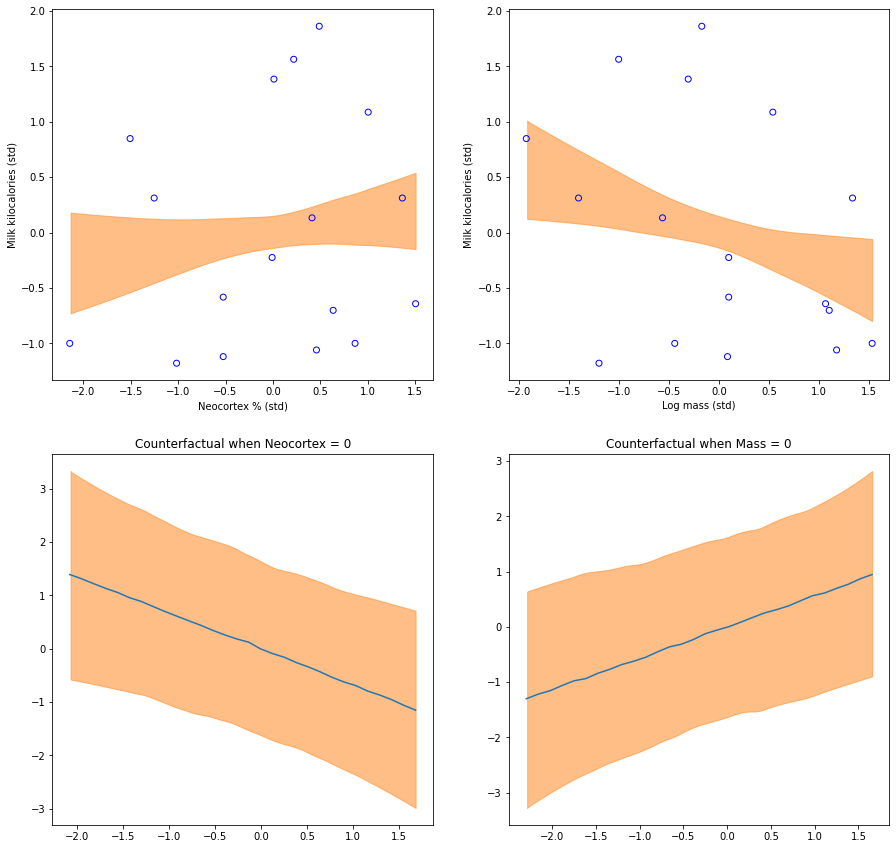

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.figsize = (30,20)

mu_mean = m5_5_draft_2_trace.posterior["mu"].mean(axis=0)
az.plot_hdi(milk['standarized_neocortex_perc'], mu_mean, ax=axs[0, 0])
axs[0, 0].scatter(milk["standarized_neocortex_perc"], milk["standarized_kcal_per_g"], facecolors="none", edgecolors="b")
axs[0, 0].set(xlabel="Neocortex % (std)", ylabel="Milk kilocalories (std)")

mu_mean_5_6 = m5_6_trace.posterior["mu"].mean(axis=0)
az.plot_hdi(milk['standarized_log_mass'], mu_mean_5_6, ax=axs[0, 1])
axs[0, 1].scatter(milk["standarized_log_mass"], milk["standarized_kcal_per_g"], facecolors="none", edgecolors="b")
axs[0, 1].set(xlabel="Log mass (std)", ylabel="Milk kilocalories (std)")

az.plot_hdi(xseq, m5_7_pp_1['K'], ax=axs[1,0])
axs[1,0].plot(xseq, m5_7_pp_1['K'].mean(0))
axs[1,0].set_title("Counterfactual when Neocortex = 0")

az.plot_hdi(standarized_neo, m5_7_pp_2['K'], ax=axs[1,1])
axs[1,1].plot(standarized_neo, m5_7_pp_2['K'].mean(0))
axs[1,1].set_title("Counterfactual when Mass = 0")

# Categorical variables